# Problem

**Дано:**

> Погодная сетка 1440х721 точек с данными по атмосферному давлению с измерениями каждые 3 часа за 28 дней летом и 28 дней зимой.

**Нужно:**

> Сделать прогноз на следующие 3 дня в каждом из двух сезонов.

**Идея:**

 > Не использовать нейронные сети, а ограничиться простыми регрессионными моделями.

 **Челлендж:**

 > Строить отдельную модель для каждой из $>10^6$ точек сетки - не лучшая идея. Плюсом следует учитывать зависимость от ссоседних точек.

 **Решение:**

 > Сделать разреженную сетку, используя экспоненциальное скользящее среднее, получить предсказания и обратной декомпозицией получить предсказания по всей сетке.

 Итог: проще было взять нейронку...



# Временные ряды

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats as st

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing


## Warmup

In [ ]:
data = pd.read_csv('data/time.txt', parse_dates=[0], dayfirst=True)

In [ ]:
data.head()

In [ ]:
groups = data['Time'].groupby(data['Time']).count()

In [ ]:
data = groups.cumsum()

In [ ]:
_ = plt.plot(data.values)
plt.show()

In [ ]:
stl_data = seasonal_decompose(data, period=7)
_= stl_data.plot()
plt.show()

### ARIMA

In [ ]:
kpss(data, nlags='legacy')

In [ ]:
new_data = {}
time_iter = pd.date_range('20190210','20190401',freq='D')
old_data = None
for i in time_iter:
    if i in data:
        new_data[i] = float(data[i])
        old_data = new_data[i]
    else:
        new_data[i] = old_data

new_data = pd.DataFrame({'Time':new_data})

In [ ]:
stl_data = seasonal_decompose(new_data['Time'], period=7)
stl_data.plot()

plt.show()

In [ ]:
new_data_without_trend = new_data.copy()[3:-3]
new_data_without_trend['Time'] = (new_data['Time'] - stl_data.trend)[3:-3]
plt.plot(new_data_without_trend)

plt.show()

In [ ]:
kpss(new_data['Time'], nlags='legacy')

In [ ]:
kpss(new_data_without_trend['Time'], nlags='legacy')

In [ ]:
plt.plot(new_data_without_trend.diff(7))

plt.show()

In [ ]:
kpss(new_data_without_trend['Time'].diff(7)[7:], nlags='legacy')

In [ ]:
arima = ARIMA(new_data_without_trend['Time'].values, order=(1,1,1)).fit()

plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(1, len(new_data_without_trend), dynamic=False))

plt.show()

In [ ]:
_ =plt.plot(arima.resid)
plt.show()
_ = plt.hist(arima.resid)
plt.show()
st.shapiro(arima.resid)

In [ ]:
arima = SARIMAX(new_data_without_trend['Time'].values, order=(1,0,1), seasonal_order=(0,2,1,7)).fit()

arima.summary()

In [ ]:
plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(0, len(new_data['Time'].values)))

plt.show()

In [ ]:
_ =plt.plot(arima.resid)
plt.show()
_ = plt.hist(arima.resid)
plt.show()
st.shapiro(arima.resid)


In [ ]:
plt.scatter(range(30), acorr_ljungbox(arima.resid, lags=30)[1])

plt.show()

In [ ]:
predictition = arima.get_prediction(0, len(new_data_without_trend)-1).conf_int()
intervals = stl_data.trend.values.flatten()[3:-3] + predictition[:, 0], stl_data.trend.values.flatten()[3:-3] + predictition[:, 1]

plt.fill_between(range(len(intervals[0])), intervals[0], intervals[1], alpha=0.2)
plt.ylim(0, 250)
plt.plot(new_data['Time'].values[3:-3], alpha=0.5, ls='--', c='r')
plt.plot(stl_data.trend.values.flatten()[3:-3]+arima.predict(0, len(new_data_without_trend)-1), c='g')

plt.show()

### ETS

In [ ]:
ets = ExponentialSmoothing(new_data['Time'].values, trend='add', seasonal='add', seasonal_periods=7).fit()
plt.plot(new_data['Time'].values, alpha=0.5, ls='--', c='r')
predicted = ets.predict(0, 60)

plt.plot(predicted)

plt.show()

## Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие два года.

In [ ]:
data = pd.read_csv('monthly-australian-wine-sales.csv', parse_dates=[0], delimiter=',')
data.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


In [ ]:
data.columns = ['date', 'wine']
data.head()

,date,wine
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


Попробуем поделить на число дней в месяце:

In [ ]:
values = data['wine'].values.copy()
days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
for i in range(len(values)):
    values[i]/=days[i%12]

Ряд не стал более регулярным, так что вернёмся к исходным данным.

STL-декомпозиция ряда:

In [ ]:
data = data.set_index(pd.DatetimeIndex(data['date']))

In [ ]:
data.head()

,date,wine
date,,
1980-01-01,1980-01-01,15136
1980-02-01,1980-02-01,16733
1980-03-01,1980-03-01,20016
1980-04-01,1980-04-01,17708
1980-05-01,1980-05-01,18019


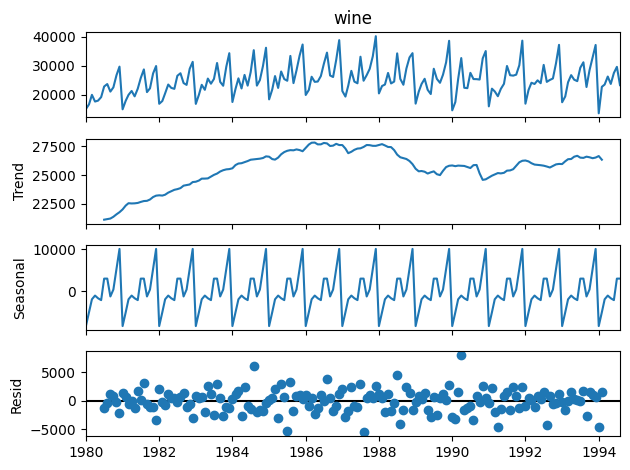

In [ ]:
stl_data = seasonal_decompose(data['wine'])
_= stl_data.plot()

0.23667537162383442


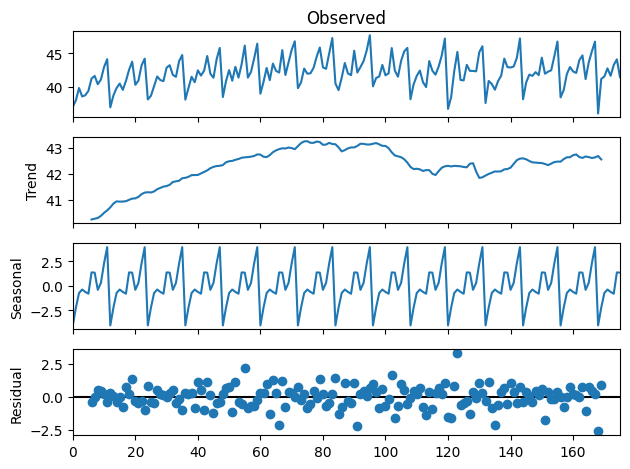

In [ ]:
transformed, lam = st.boxcox(data['wine'])
data['bc'] = transformed
print (lam)
stl_data = seasonal_decompose(transformed, period=12)
_= stl_data.plot()

### ARIMA

Стационарность:

In [ ]:
kpss(data['wine'], nlags='legacy')

(0.5448466202836393,
 0.03156607651269385,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Cделаем сезонное дифференцирование:

(0.5200996002022095,
 0.03713972968418706,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

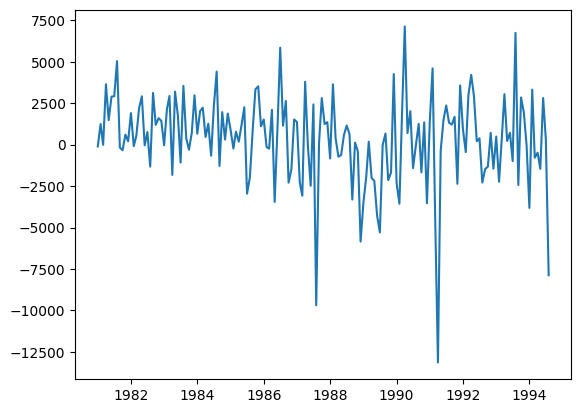

In [ ]:
diff_ts = data['wine'].diff(12)[12:]
plt.plot(diff_ts)
kpss(diff_ts, nlags='legacy')

Ряд всё ещё нестационарен. Проведём ещё одно дифференцирование:

<ipython-input-11-9a328f4c93bf>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(diff_diff_ts, nlags='legacy')


(0.1466436817476703,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

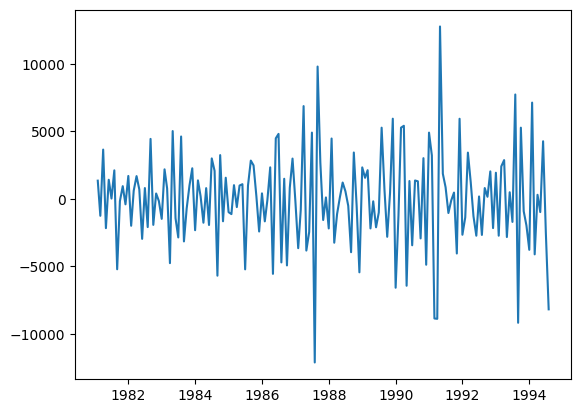

In [ ]:
diff_diff_ts = diff_ts.diff(1)[1:]
plt.plot(diff_diff_ts)
kpss(diff_diff_ts, nlags='legacy')


Для полученного ряда гипотеза стационарности не отвергается

Посмотрим на ACF и PACF полученного продифференцированного ряда:

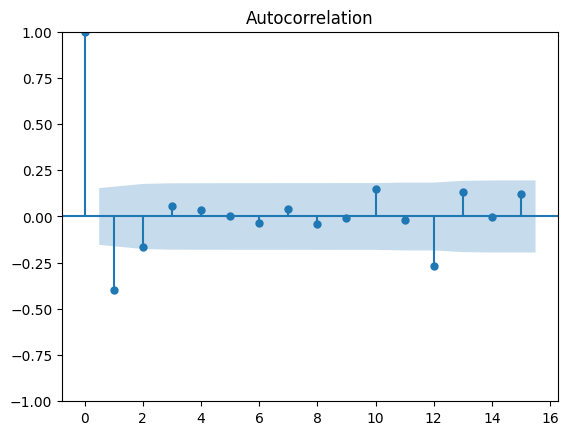

In [ ]:
plot_acf(diff_diff_ts, lags=15)

plt.show()

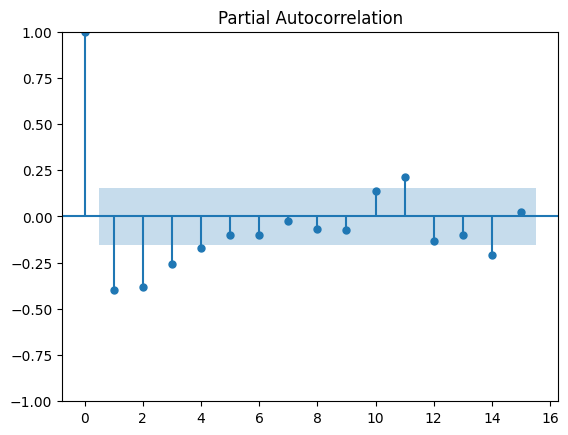

In [ ]:
plot_pacf(diff_diff_ts, lags=15)

plt.show()

На ACF значимы лаги 1 и 12, на PACF — 1-3. Будем искать модель, оптимальную по AICc, в окрестности ARIMA(3,1,1)

In [ ]:
for i in range(-1,2):
    for k in range(-1, 2):
        order = (3+i,1,1+k)
        try:
            arima = ARIMA(data['wine'].values, order=order).fit()
            print(arima.summary())
        except:
            pass

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  176
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1766.250
Date:                Tue, 29 Aug 2023   AIC                           3538.500
Time:                        06:51:37   BIC                           3547.995
Sample:                             0   HQIC                          3542.352
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4210      0.079     -5.340      0.000      -0.576      -0.266
ar.L2         -0.4234      0.077     -5.507      0.000      -0.574      -0.273
sigma2      3.376e+07   9.99e-10   3.38e+16      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  176
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1744.163
Date:                Tue, 29 Aug 2023   AIC                           3502.327
Time:                        06:51:41   BIC                           3524.480
Sample:                             0   HQIC                          3511.313
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0562      0.746      0.075      0.940      -1.405       1.518
ar.L2         -0.1929      0.149     -1.291      0.197      -0.486       0.100
ar.L3         -0.0204      0.224     -0.091      0.9

In [ ]:
arima = ARIMA(data['wine'].values, order=(2,1,1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  176
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1746.125
Date:                Tue, 29 Aug 2023   AIC                           3500.251
Time:                        06:51:41   BIC                           3512.910
Sample:                             0   HQIC                          3505.386
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1420      0.109      1.307      0.191      -0.071       0.355
ar.L2         -0.2572      0.125     -2.063      0.039      -0.502      -0.013
ma.L1         -0.9074      0.052    -17.526      0.0

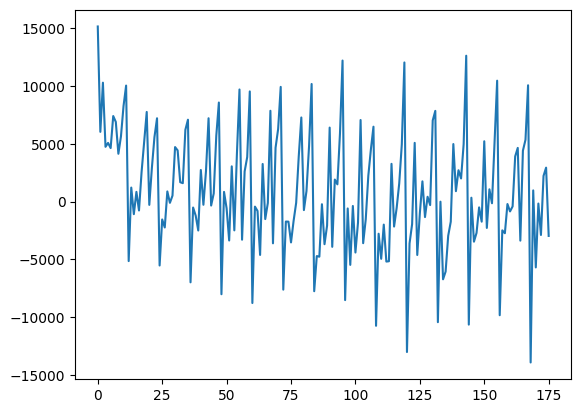

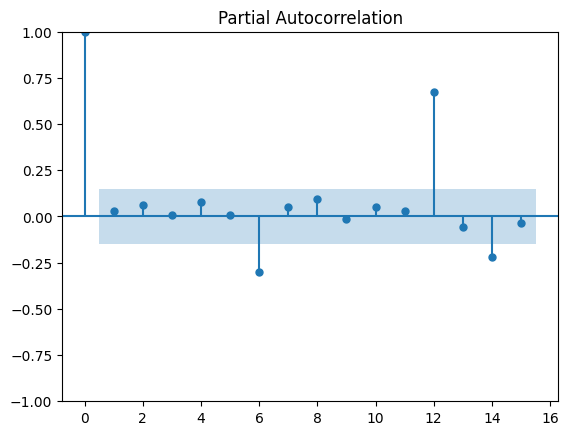

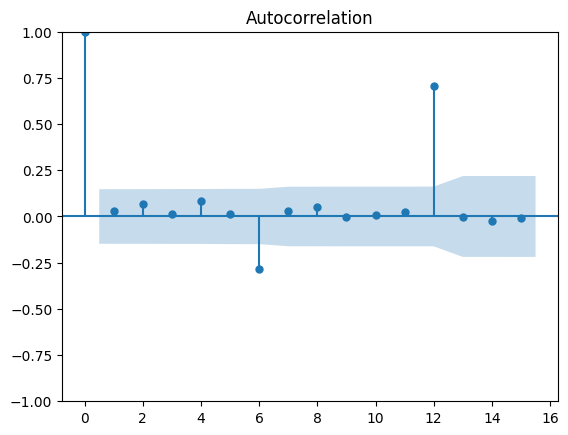

In [ ]:
plt.plot(arima.resid)
plot_pacf(arima.resid, lags=15)
plot_acf(arima.resid, lags=15)

plt.show()

In [ ]:
for i in range(-1,2):
    for j in range(-1, 2):
        order = (3+i, 1, 1+j)
        sorder = (1, 1, 1, 12)
        try:
            arima = SARIMAX(data['wine'].values, order=order, seasonal_order=sorder).fit()
            print(arima.summary())
        except:
            pass

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  176
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1532.390
Date:                              Tue, 29 Aug 2023   AIC                           3074.781
Time:                                      06:51:43   BIC                           3090.249
Sample:                                           0   HQIC                          3081.061
                                              - 176                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4661      0.041    -11.448      0.000      -0.546      -0.386
ar.L2         -0.29

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  176
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1527.611
Date:                              Tue, 29 Aug 2023   AIC                           3071.221
Time:                                      06:51:50   BIC                           3095.971
Sample:                                           0   HQIC                          3081.269
                                              - 176                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5570      1.984     -0.281      0.779      -4.446       3.332
ar.L2         -0.05

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  176
Model:             SARIMAX(4, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1527.609
Date:                              Tue, 29 Aug 2023   AIC                           3073.219
Time:                                      06:51:54   BIC                           3101.063
Sample:                                           0   HQIC                          3084.523
                                              - 176                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5316      2.438     -0.218      0.827      -5.310       4.247
ar.L2         -0.07

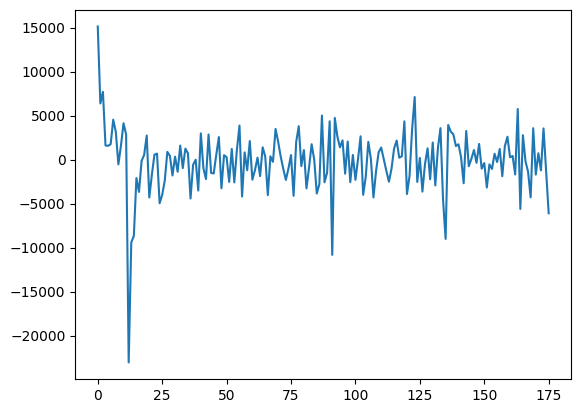

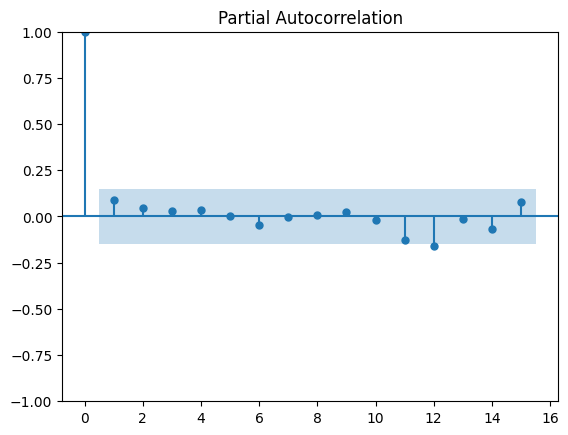

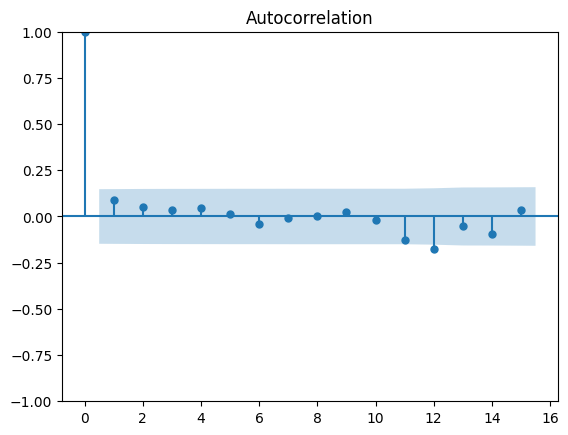

In [ ]:
arima = SARIMAX(data['wine'].values, order=(2,1,1), seasonal_order=(1, 1, 1, 12)).fit()


plt.plot(arima.resid)
plot_pacf(arima.resid, lags=15)
plot_acf(arima.resid, lags=15)

plt.show()

Q-Q plot:

ShapiroResult(statistic=0.8828683495521545, pvalue=1.6304729788529926e-10)


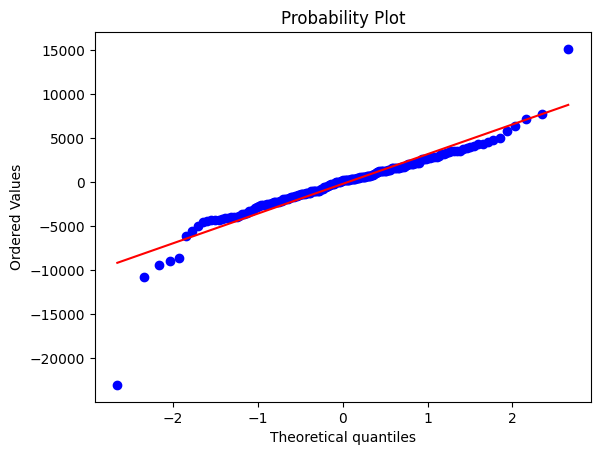

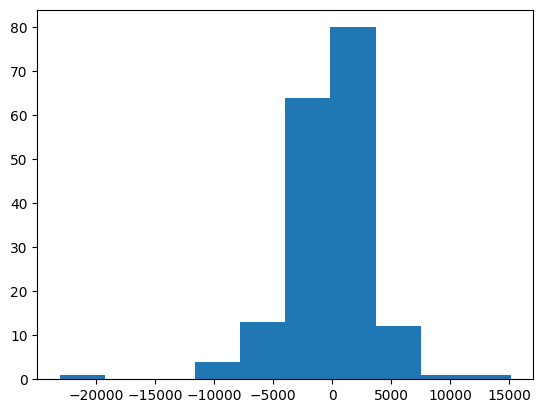

In [ ]:
_ = st.probplot(arima.resid, plot=plt)
print (st.shapiro(arima.resid))
plt.show()
plt.hist(arima.resid)

plt.show()

In [ ]:
arima = SARIMAX(data['wine'].values[:-12], order=(3,1,1), seasonal_order=(1,1,1,12)).fit()
predicted = arima.predict(0, data.shape[0])

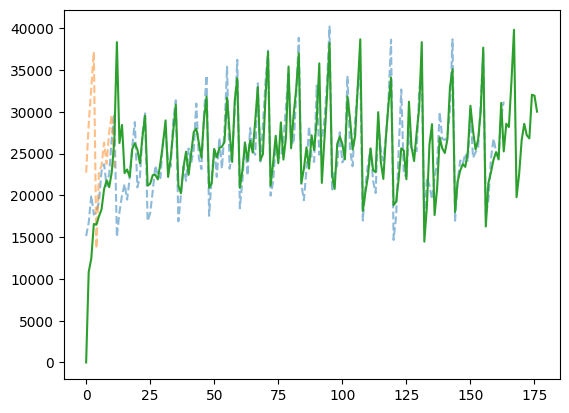

In [ ]:
plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
arima = SARIMAX(data['wine'].values[:-12], order=(3,1,1), seasonal_order=(1,1,1,12)).fit()
predicted = arima.predict(data.shape[0]-12, data.shape[0]-1, dynamic=True)

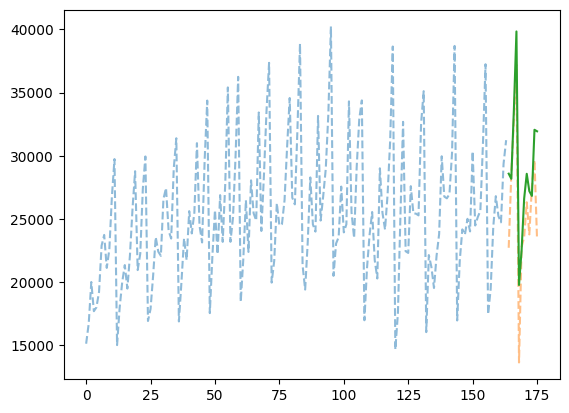

In [ ]:
plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), predicted)

plt.show()

### ETS

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


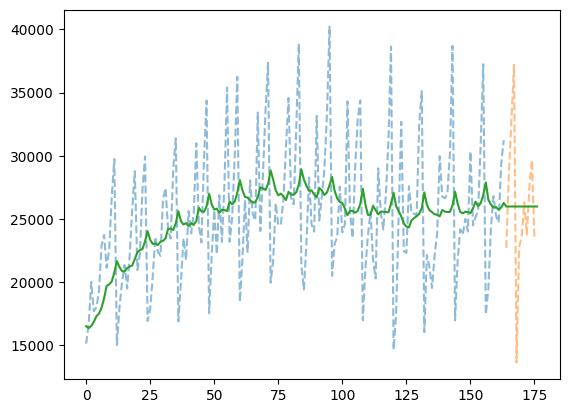

In [ ]:
ets = ExponentialSmoothing(data['wine'].values[12:]).fit(optimized=True)

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


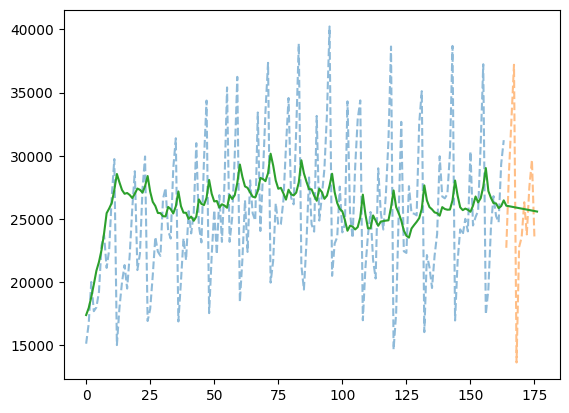

In [ ]:
ets = ExponentialSmoothing(data['wine'].values[12:],  trend='add').fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


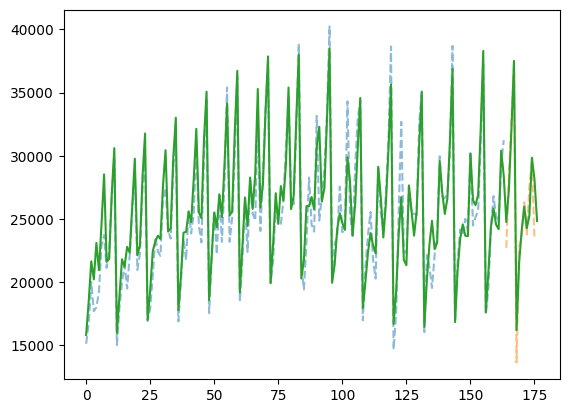

In [ ]:
ets = ExponentialSmoothing(data['wine'].values[12:], seasonal='mul', trend='add', seasonal_periods=12).fit()

predicted = ets.predict(0, data.shape[0])

plt.plot(data['wine'].values[:-12], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-12]), len(data['wine'])), data['wine'].values[-12:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

ShapiroResult(statistic=0.9533318877220154, pvalue=2.8098982511437498e-05)


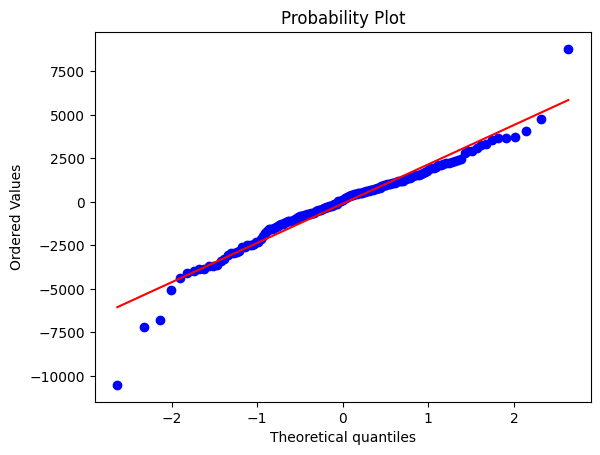

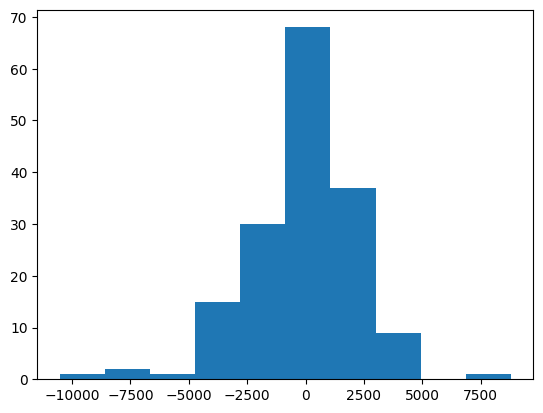

In [ ]:
_ = st.probplot(ets.resid, plot=plt)
print (st.shapiro(ets.resid))
plt.show()

plt.hist(ets.resid)
plt.show()